# AutoGluon Tabular Benchmark

This notebook implements a benchmark comparing AutoGluon's tabular capabilities with traditional machine learning approach.

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from typing import Dict, List, Tuple

# AutoGluon imports
from autogluon.tabular import TabularPredictor

# Dataset registry
from auto_mm_bench.datasets import dataset_registry, _TEXT

# Metrics and feature engineering
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder

warnings.filterwarnings('ignore')
np.random.seed(42)

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Dataset Exploration

In [2]:
# Get available datasets
available_datasets = dataset_registry.list_keys()
print(f"Total available datasets: {len(available_datasets)}")
print("\nAvailable datasets:")
for i, dataset_key in enumerate(available_datasets, 1):
    print(f"{i:2d}. {dataset_key}")

Total available datasets: 27

Available datasets:
 1. product_sentiment_machine_hack
 2. jigsaw_unintended_bias
 3. jigsaw_unintended_bias100K
 4. google_qa_label
 5. google_qa_answer_helpful
 6. google_qa_answer_plausible
 7. google_qa_answer_type_procedure
 8. google_qa_answer_type_reason_explanation
 9. google_qa_question_type_reason_explanation
10. google_qa_answer_satisfaction
11. women_clothing_review
12. melbourne_airbnb
13. mercari_price_suggestion
14. ae_price_prediction
15. mercari_price_suggestion100K
16. imdb_genre_prediction
17. fake_job_postings
18. kick_starter_funding
19. jc_penney_products
20. wine_reviews
21. news_popularity
22. news_channel
23. news_popularity2
24. fake_job_postings2
25. bookprice_prediction
26. data_scientist_salary
27. california_house_price


In [3]:
def explore_dataset(dataset_name: str) -> Dict:
    """Explore a dataset and return key information."""
    try:
        train_dataset = dataset_registry.create(dataset_name, 'train')
        test_dataset = dataset_registry.create(dataset_name, 'test')
        
        # Get basic info
        info = {
            'name': dataset_name,
            'problem_type': train_dataset.problem_type,
            'metric': train_dataset.metric,
            'n_train': len(train_dataset.data),
            'n_test': len(test_dataset.data),
            'n_features': len(train_dataset.feature_columns),
            'feature_columns': train_dataset.feature_columns,
            'label_columns': train_dataset.label_columns,
            'feature_types': train_dataset.feature_types
        }
        
        # Identify text columns
        text_columns = [col for col, ftype in zip(train_dataset.feature_columns, train_dataset.feature_types) 
                       if ftype == _TEXT]
        info['text_columns'] = text_columns
        info['n_text_columns'] = len(text_columns)
        
        # Get data types and missing values
        train_data = train_dataset.data
        info['data_types'] = train_data.dtypes.to_dict()
        info['missing_values'] = train_data.isnull().sum().to_dict()
        
        return info
        
    except Exception as e:
        print(f"Error exploring {dataset_name}: {e}")
        return None

# Explore a few key datasets
key_datasets = ['product_sentiment_machine_hack', 'qaa', 'jigsaw_unintended_bias100K']
dataset_info = {}

for dataset_name in key_datasets:
    if dataset_name in available_datasets:
        info = explore_dataset(dataset_name)
        if info:
            dataset_info[dataset_name] = info
            print(f"\n{'='*50}")
            print(f"Dataset: {info['name']}")
            print(f"Problem type: {info['problem_type']}")
            print(f"Metric: {info['metric']}")
            print(f"Train samples: {info['n_train']:,}")
            print(f"Test samples: {info['n_test']:,}")
            print(f"Features: {info['n_features']} (Text: {info['n_text_columns']})")
            print(f"Text columns: {info['text_columns']}")


Dataset: product_sentiment_machine_hack
Problem type: multiclass
Metric: acc
Train samples: 5,091
Test samples: 1,273
Features: 2 (Text: 1)
Text columns: ['Product_Description']

Dataset: jigsaw_unintended_bias100K
Problem type: binary
Metric: roc_auc
Train samples: 100,000
Test samples: 25,000
Features: 30 (Text: 1)
Text columns: ['comment_text']


## AutoGluon Tabular Benchmark Implementation

We'll implement and compare several tabular learning approaches:
1. **AG-Stack (no text)**: AutoGluon with stack ensembling, ignoring text columns
2. **AG-Stack + N-Gram**: AutoGluon with N-Gram featurization for text
3. **Random Forest + TF-IDF**: Baseline Random Forest with manual text feature engineering

In [4]:
class AutoGluonBenchmark:
    def __init__(self, time_limit: int = 600, preset: str = 'medium_quality'):
        self.time_limit = time_limit
        self.preset = preset
        self.results = {}
        
    def prepare_data(self, dataset_name: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Load and prepare train/test data."""
        train_dataset = dataset_registry.create(dataset_name, 'train')
        test_dataset = dataset_registry.create(dataset_name, 'test')
        
        train_data = train_dataset.data.copy()
        test_data = test_dataset.data.copy()
        
        return train_data, test_data, train_dataset
    
    def run_ag_stack_no_text(self, dataset_name: str) -> Dict:
        """AG-Stack: AutoGluon ignoring text columns."""
        print(f"\nRunning AG-Stack (no text) on {dataset_name}...")
        
        train_data, test_data, train_dataset = self.prepare_data(dataset_name)
        
        # Remove text columns
        text_columns = [col for col, ftype in zip(train_dataset.feature_columns, train_dataset.feature_types) 
                       if ftype == _TEXT]
        
        train_no_text = train_data.drop(columns=text_columns)
        test_no_text = test_data.drop(columns=text_columns)
        
        # Train AutoGluon
        predictor = TabularPredictor(
            label=train_dataset.label_columns[0],
            problem_type=train_dataset.problem_type,
            eval_metric=train_dataset.metric
        )
        
        start_time = time.time()
        predictor.fit(
            train_no_text,
            time_limit=self.time_limit,
            presets=self.preset,
            ag_args_ensemble={'fold_fitting_strategy': 'sequential_local'}
        )
        train_time = time.time() - start_time
        
        # Make predictions
        predictions = predictor.predict(test_no_text)
        
        # Calculate metric
        true_labels = test_data[train_dataset.label_columns[0]]
        score = self.calculate_metric(true_labels, predictions, train_dataset.metric, train_dataset.problem_type)
        
        return {
            'method': 'AG-Stack (no text)',
            'score': score,
            'metric': train_dataset.metric,
            'train_time': train_time,
            'n_features_used': len(train_no_text.columns) - 1
        }
    
    def run_ag_stack_with_ngram(self, dataset_name: str) -> Dict:
        """AG-Stack + N-Gram: AutoGluon with N-Gram text featurization."""
        print(f"\nRunning AG-Stack + N-Gram on {dataset_name}...")
        
        train_data, test_data, train_dataset = self.prepare_data(dataset_name)
        
        # Train AutoGluon with N-Gram featurization (AutoGluon handles this automatically)
        predictor = TabularPredictor(
            label=train_dataset.label_columns[0],
            problem_type=train_dataset.problem_type,
            eval_metric=train_dataset.metric
        )
        
        start_time = time.time()
        predictor.fit(
            train_data,
            time_limit=self.time_limit,
            presets=self.preset,
            ag_args_ensemble={'fold_fitting_strategy': 'sequential_local'}
        )
        train_time = time.time() - start_time
        
        # Make predictions
        predictions = predictor.predict(test_data)
        
        # Calculate metric
        true_labels = test_data[train_dataset.label_columns[0]]
        score = self.calculate_metric(true_labels, predictions, train_dataset.metric, train_dataset.problem_type)
        
        return {
            'method': 'AG-Stack + N-Gram',
            'score': score,
            'metric': train_dataset.metric,
            'train_time': train_time,
            'n_features_used': len(train_data.columns) - 1
        }
    
    def run_random_forest_tfidf(self, dataset_name: str) -> Dict:
        """Random Forest with TF-IDF text features and basic feature engineering."""
        print(f"\nRunning Random Forest + TF-IDF on {dataset_name}...")
        
        train_data, test_data, train_dataset = self.prepare_data(dataset_name)
        
        # Identify text and non-text columns
        text_columns = [col for col, ftype in zip(train_dataset.feature_columns, train_dataset.feature_types) 
                       if ftype == _TEXT]
        numeric_columns = [col for col in train_dataset.feature_columns if col not in text_columns]
        
        start_time = time.time()
        
        # Prepare features
        if text_columns:
            # Combine all text columns into one
            train_text = train_data[text_columns].fillna('').apply(lambda x: ' '.join(x.astype(str)), axis=1)
            test_text = test_data[text_columns].fillna('').apply(lambda x: ' '.join(x.astype(str)), axis=1)
            
            # TF-IDF vectorization
            tfidf = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
            train_tfidf = tfidf.fit_transform(train_text).toarray()
            test_tfidf = tfidf.transform(test_text).toarray()
            
            # Create TF-IDF feature names
            tfidf_feature_names = [f'tfidf_{i}' for i in range(train_tfidf.shape[1])]
            train_tfidf_df = pd.DataFrame(train_tfidf, columns=tfidf_feature_names, index=train_data.index)
            test_tfidf_df = pd.DataFrame(test_tfidf, columns=tfidf_feature_names, index=test_data.index)
        else:
            train_tfidf_df = pd.DataFrame(index=train_data.index)
            test_tfidf_df = pd.DataFrame(index=test_data.index)
        
        # Prepare numeric features
        if numeric_columns:
            train_numeric = train_data[numeric_columns].fillna(0)
            test_numeric = test_data[numeric_columns].fillna(0)
            
            # Basic feature engineering: add interaction features for top numeric columns
            if len(numeric_columns) > 1:
                # Add simple polynomial features for top 3 numeric columns
                top_cols = numeric_columns[:min(3, len(numeric_columns))]
                for i, col1 in enumerate(top_cols):
                    for col2 in top_cols[i+1:]:
                        if train_numeric[col1].dtype in ['int64', 'float64'] and train_numeric[col2].dtype in ['int64', 'float64']:
                            train_numeric[f'{col1}_x_{col2}'] = train_numeric[col1] * train_numeric[col2]
                            test_numeric[f'{col1}_x_{col2}'] = test_numeric[col1] * test_numeric[col2]
        else:
            train_numeric = pd.DataFrame(index=train_data.index)
            test_numeric = pd.DataFrame(index=test_data.index)
        
        # Combine all features
        X_train = pd.concat([train_numeric, train_tfidf_df], axis=1)
        X_test = pd.concat([test_numeric, test_tfidf_df], axis=1)
        
        # Prepare labels
        y_train = train_data[train_dataset.label_columns[0]]
        y_test = test_data[train_dataset.label_columns[0]]
        
        # Handle categorical labels for classification
        if train_dataset.problem_type in ['binary', 'multiclass']:
            le = LabelEncoder()
            y_train_encoded = le.fit_transform(y_train)
            y_test_encoded = le.transform(y_test)
            
            # Train Random Forest Classifier
            rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            rf.fit(X_train, y_train_encoded)
            
            if train_dataset.problem_type == 'binary' and train_dataset.metric.lower() in ['auc', 'roc_auc']:
                # For AUC, we need probabilities
                predictions = rf.predict_proba(X_test)[:, 1]
                true_labels = y_test_encoded
            else:
                predictions = rf.predict(X_test)
                true_labels = y_test_encoded
        else:
            # Regression
            rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
            rf.fit(X_train, y_train)
            predictions = rf.predict(X_test)
            true_labels = y_test
        
        train_time = time.time() - start_time
        
        # Calculate metric
        score = self.calculate_metric(true_labels, predictions, train_dataset.metric, train_dataset.problem_type)
        
        return {
            'method': 'Random Forest + TF-IDF',
            'score': score,
            'metric': train_dataset.metric,
            'train_time': train_time,
            'n_features_used': X_train.shape[1]
        }
    
    def calculate_metric(self, y_true, y_pred, metric_name: str, problem_type: str) -> float:
        """Calculate the appropriate metric based on problem type."""
        if problem_type == 'binary':
            if metric_name.lower() in ['auc', 'roc_auc']:
                return roc_auc_score(y_true, y_pred)
            else:
                return accuracy_score(y_true, y_pred)
        elif problem_type == 'multiclass':
            return accuracy_score(y_true, y_pred)
        elif problem_type == 'regression':
            return r2_score(y_true, y_pred)
        else:
            raise ValueError(f"Unknown problem type: {problem_type}")
    
    def run_full_benchmark(self, dataset_name: str) -> Dict:
        """Run all benchmark methods on a dataset."""
        print(f"\n{'='*60}")
        print(f"Running full tabular benchmark on: {dataset_name}")
        print(f"{'='*60}")
        
        results = []
        
        try:
            # AG-Stack without text
            result1 = self.run_ag_stack_no_text(dataset_name)
            results.append(result1)
            print(f"{result1['method']}: {result1['score']:.4f} {result1['metric']}")
        except Exception as e:
            print(f"AG-Stack (no text) failed: {e}")
        
        try:
            # AG-Stack with N-Gram
            result2 = self.run_ag_stack_with_ngram(dataset_name)
            results.append(result2)
            print(f"{result2['method']}: {result2['score']:.4f} {result2['metric']}")
        except Exception as e:
            print(f"AG-Stack + N-Gram failed: {e}")
        
        try:
            # Random Forest with TF-IDF
            result3 = self.run_random_forest_tfidf(dataset_name)
            results.append(result3)
            print(f"{result3['method']}: {result3['score']:.4f} {result3['metric']}")
        except Exception as e:
            print(f"Random Forest + TF-IDF failed: {e}")
        
        self.results[dataset_name] = results
        return results

## Run Benchmark on Selected Dataset

Running the benchmark to replicate the results.

In [5]:
# Initialize benchmark for detailed analysis
benchmark = AutoGluonBenchmark(time_limit=300, preset='medium_quality')  # 5 minutes per method

# Focus on product sentiment dataset for detailed analysis
target_dataset = 'product_sentiment_machine_hack'

print(f"DETAILED BENCHMARK ANALYSIS")
print(f"Dataset: {target_dataset}")
print(f"{'='*60}")

# Run comprehensive benchmark
results = benchmark.run_full_benchmark(target_dataset)

No path specified. Models will be saved in: "AutogluonModels/ag-20251010_010008"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.3
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #33~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Sep 19 17:02:30 UTC 2
CPU Count:          12
Memory Avail:       4.81 GB / 14.94 GB (32.2%)
Disk Space Avail:   129.87 GB / 548.95 GB (23.7%)
Presets specified: ['medium_quality']
Using hyperparameters preset: hyperparameters='default'


Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "/home/edo/Sapienza/Thesis/thesis/AutogluonModels/ag-20251010_010008"
Train Data Rows:    5091
Train Data Columns: 3
Label Column:       Sentiment
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 4
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4937.60 MB
	Train Data (Original)  Memory Usage: 0.12 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw

DETAILED BENCHMARK ANALYSIS
Dataset: product_sentiment_machine_hack

Running full tabular benchmark on: product_sentiment_machine_hack

Running AG-Stack (no text) on product_sentiment_machine_hack...


Fitting model: NeuralNetFastAI ... Training model for up to 299.96s of the 299.96s of remaining time.
	Failed to import torch or check CUDA availability!Please ensure you have the correct version of PyTorch installed by running `pip install -U torch`
	Fitting with cpus=6, gpus=0, mem=0.0/4.8 GB
		Import fastai failed. A quick tip is to install via `pip install autogluon.tabular[fastai]==1.4.0`. 
Fitting model: LightGBMXT ... Training model for up to 299.76s of the 299.76s of remaining time.
	Failed to import torch or check CUDA availability!Please ensure you have the correct version of PyTorch installed by running `pip install -U torch`
	Fitting with cpus=6, gpus=0, mem=0.0/4.8 GB
		`import lightgbm` failed. A quick tip is to install via `pip install autogluon.tabular[lightgbm]==1.4.0`.
Fitting model: LightGBM ... Training model for up to 299.62s of the 299.62s of remaining time.
	Failed to import torch or check CUDA availability!Please ensure you have the correct version of PyTorch in

AG-Stack (no text): 0.8727 acc

Running AG-Stack + N-Gram on product_sentiment_machine_hack...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['Product_Description']
			CountVectorizer fit with vocabulary size = 633
		Reducing Vectorizer vocab size from 633 to 499 to avoid OOM error
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 3 | ['Unnamed: 0', 'Text_ID', 'Product_Type']
		('object', ['text']) : 1 | ['Product_Description']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['Product_Description']
		('int', [])                         :   3 | ['Unnamed: 0', 'Text_ID', 'Product_Type']
		('int', ['binned', 'text_special']) :  32 | ['Product_Description.char_count', 'Product_Description.word_count', 'Product_Description.capital_ratio', 

AG-Stack + N-Gram: 0.8892 acc

Running Random Forest + TF-IDF on product_sentiment_machine_hack...
Random Forest + TF-IDF: 0.8932 acc


## Results Analysis and Visualization

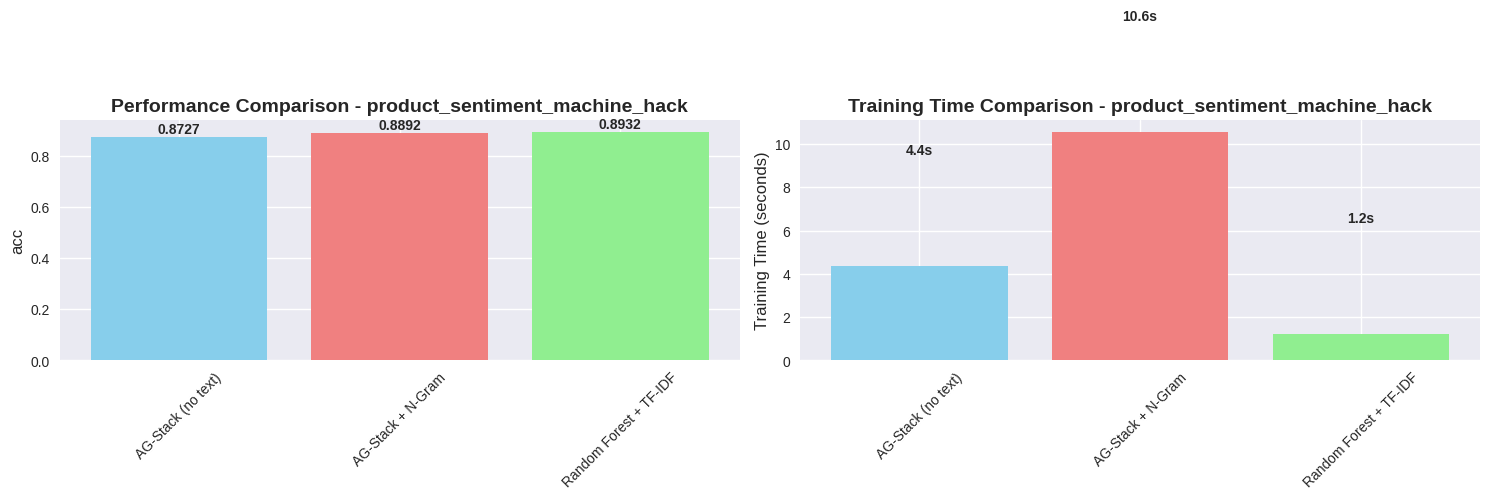


BENCHMARK RESULTS - product_sentiment_machine_hack
1. AG-Stack (no text):
   Score: 0.8727 acc
   Training Time: 4.36 seconds
   Features Used: 3

2. AG-Stack + N-Gram:
   Score: 0.8892 acc
   Training Time: 10.56 seconds
   Features Used: 4

3. Random Forest + TF-IDF:
   Score: 0.8932 acc
   Training Time: 1.21 seconds
   Features Used: 1001

Improvements over baseline (AG-Stack no text):
  AG-Stack + N-Gram: +1.89%
  Random Forest + TF-IDF: +2.34%


In [6]:
def plot_benchmark_results(results: List[Dict], dataset_name: str):
    """Plot benchmark results."""
    if not results:
        print("No results to plot.")
        return
    
    methods = [r['method'] for r in results]
    scores = [r['score'] for r in results]
    times = [r['train_time'] for r in results]
    metric_name = results[0]['metric']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Performance comparison
    bars1 = ax1.bar(methods, scores, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax1.set_title(f'Performance Comparison - {dataset_name}', fontsize=14, fontweight='bold')
    ax1.set_ylabel(f'{metric_name}', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, score in zip(bars1, scores):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Training time comparison
    bars2 = ax2.bar(methods, times, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax2.set_title(f'Training Time Comparison - {dataset_name}', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Training Time (seconds)', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, time_val in zip(bars2, times):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\n{'='*60}")
    print(f"BENCHMARK RESULTS - {dataset_name}")
    print(f"{'='*60}")
    
    for i, result in enumerate(results, 1):
        print(f"{i}. {result['method']}:")
        print(f"   Score: {result['score']:.4f} {result['metric']}")
        print(f"   Training Time: {result['train_time']:.2f} seconds")
        print(f"   Features Used: {result['n_features_used']}")
        print()
    
    # Calculate improvements
    if len(results) >= 2:
        baseline_score = results[0]['score']  # AG-Stack no text
        print("Improvements over baseline (AG-Stack no text):")
        for result in results[1:]:
            improvement = ((result['score'] - baseline_score) / baseline_score) * 100
            print(f"  {result['method']}: {improvement:+.2f}%")

# Visualize results
if results:
    plot_benchmark_results(results, target_dataset)